# Introduction to Computer Vision

In this session, we will discuss:

- Angles
- Distance
- Distortions

In [1]:
# import packages needed
from IPython.display import HTML
import matplotlib.image as mpimg
import numpy as np
import cv2
import imutils
import math

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import sys

print(sys.version_info)
print(cv2.__version__)

sys.version_info(major=3, minor=8, micro=5, releaselevel='final', serial=0)
4.4.0


## Find Ball

When a picture is taken, this is taken from a specific height and angle of a camera.  Given the camera angle, you will see a different perspective regarding how near or far an object is.  In this lesson, we will discuss a simple technique on how to calibrate for these perspectives but just keep in mind that there are more precise ways to calculate how far and where something is.

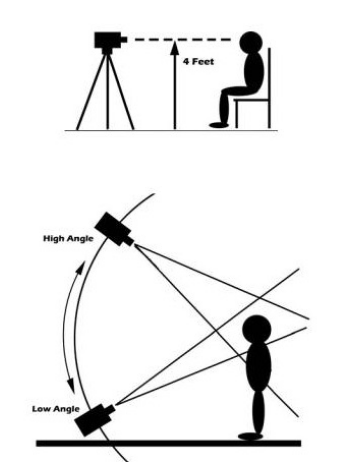

In [3]:
image_perspective = mpimg.imread('camera_angle_small.jpg')
plt.figure(figsize=(6, 10))
plt.imshow(image_perspective)
plt.axis('off')
plt.show()

del(image_perspective)

### Examples of Perspectives

In the two pictures below, the puppies picture is taking from above.  The upper right corner pixel 
is actually not that far away.  I estimate that it's only less than a foot from the center pixel.

Whereas, in the German Shepherd line up with their trainers, the upper right corner pixel is in 
fact much further in real life distance than the center pixel.  The right hand corner is probably 
many feet away from the center pixel.

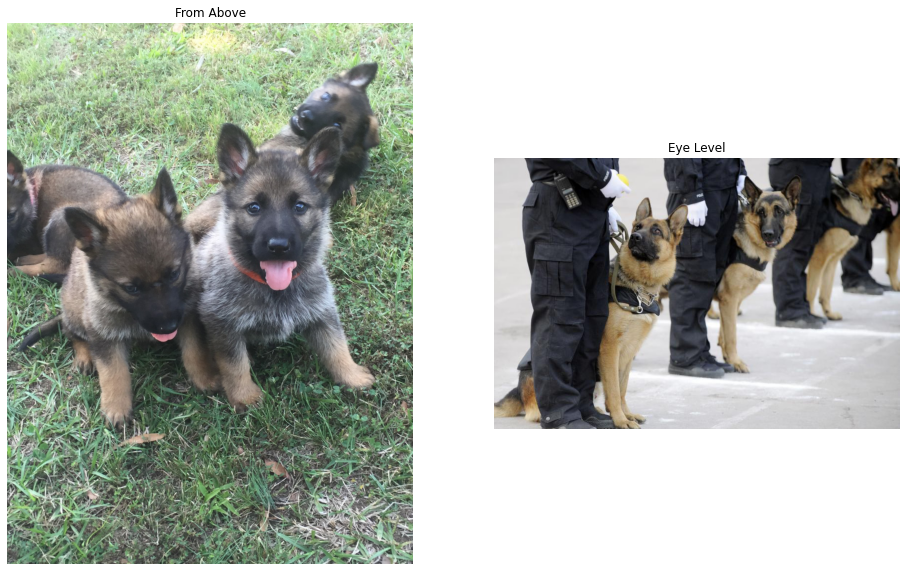

In [4]:
image_above = mpimg.imread('german-shepherd-pups-from-above.jpg')
image_level = mpimg.imread('german-shepherd-police-lineup.jpg')

plt.figure(figsize=(16, 16))
plt.subplot(1, 2, 1)
plt.title("From Above")
plt.axis('off')
plt.imshow(image_above)

plt.subplot(1, 2, 2)
plt.title("Eye Level")
plt.imshow(image_level)
plt.axis('off')

plt.show()

del(image_above, image_level)

I have manufactured some pictures with our powercell ball to show the different perspectives.  A ball that is closer to the camera will appear bigger but the same ball that is further away will appear smaller.  

Here, I've super-imposed where the camera lens is.

image has width: 1200 and height 900


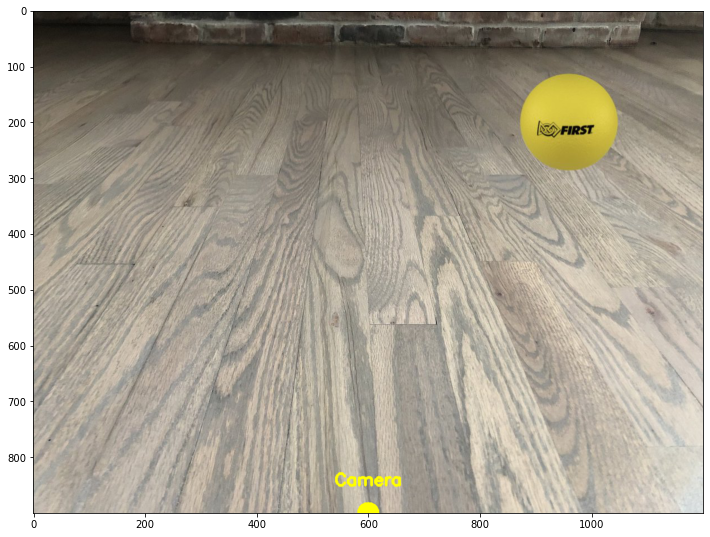

In [5]:
image = mpimg.imread('woodfloor_rightball1.jpg')

image1 = image.copy()
(height, width, depth) = image.shape

print("image has width: %i and height %i" %(width, height))

# Show the camera coordinate
cv2.circle(image1,(int(width/2), height), 20, (255, 255, 0), -1)
cv2.putText(image1, "Camera", (int(width/2)-60, height-50), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 3)

plt.figure(figsize=(12, 12))
plt.imshow(image1)
plt.show()

Using the concepts we learned from last lesson, we carry over the find_and_draw_circles( ) function and ShapeDetector( ) class here.

In [6]:
# ShapeDetector class from last session

class ShapeDetector:
    def __init__(self):
        pass

    def detect(self, c):
        # initialize the shape name and approximate the contour
        shape = "unidentified"
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.04 * peri, True)

        # if the shape is a triangle, it will have 3 vertices
        if len(approx) == 3:
            shape = "triangle"

        # if the shape has 4 vertices, it is either a square or
        # a rectangle
        elif len(approx) == 4:
            # compute the bounding box of the contour and use the
            # bounding box to compute the aspect ratio
            (x, y, w, h) = cv2.boundingRect(approx)
            ar = w / float(h)

            # a square will have an aspect ratio that is approximately
            # equal to one, otherwise, the shape is a rectangle
            shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"

        # if the shape is a pentagon, it will have 5 vertices
        elif len(approx) == 5:
            shape = "pentagon"

        # otherwise, we assume the shape is a circle
        else:
            shape = "circle"

        # return the name of the shape
        return shape

As carried over from last lesson, we have our find_and_draw_circles( ) function with some updated debug statements.

In [7]:
def find_and_draw_circles(image, lower_color_hsv, upper_color_hsv, min_area_size, 
                          kernel=3, output_text=True, print_centroids=True):
    """
    This takes in a color image, a lower HSV color and an upper HSV color range
    and a minimum pixel area size to detect a circle
    """
    _image = image.copy()
    
    # Blur and convert image to HSV
    _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
    _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
    # Mask the image using the lower/upper hsv range
    _mask_img = cv2.inRange(_hsv_img, lower_color_hsv, upper_color_hsv)
    
    # Find the contours
    _contours = cv2.findContours(_mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _contours = imutils.grab_contours(_contours)
   
    # Initialize ShapeDetector
    _sd = ShapeDetector()
       
    # Loop through contours to find circles
    for _c in _contours:
        # compute the center of the contour, then detect the name of the
        # shape using only the contour

        # M is the moment (weighted average of the image pixel intensity)
        _M = cv2.moments(_c)
        _area = cv2.contourArea(_c)

        # cX is the x coordinate of the centroid
        # cY is the y coordinate of the centroid
        # We wrap this in a try/except clause due to a division
        #    so we can trap a division by zero
        try:
            _cX = int((_M["m10"] / _M["m00"]))
            _cY = int((_M["m01"] / _M["m00"]))
        except:
            _cX = 0
            _cY = 0

        _shape = _sd.detect(_c)

        if (_shape == "circle") and (_area >= min_area_size):  
            if print_centroids:
                print("shape: ", shape, "area: ", _area, "center: (", _cX,",", _cY,")")
                
            # Drawing each contour in green (0, 255, 0) on top of the original image
            cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)

            cv2.circle(_image,(_cX, _cY), 6, (255, 0, 0), -1)
                
            if output_text:
                # Display the text for the image shape
                _center = "(%i, %i)"%(_cX, _cY)
                cv2.putText(_image, _center, (_cX+10, _cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
    
    return _image

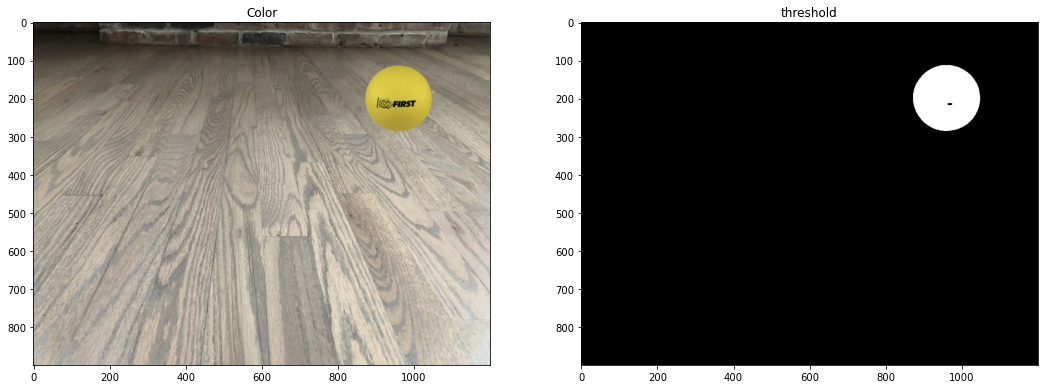

In [8]:
# yellow_lower = np.array([90, 100, 100])
# yellow_upper = np.array([100, 255, 255])

# Calibrated the colors to work best for this background
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])

blur_img = cv2.GaussianBlur(image, (31,31), 0)
image_hsv = cv2.cvtColor(blur_img, cv2.COLOR_BGR2HSV)
new_field = cv2.inRange(image_hsv, yellow_lower, yellow_upper)

plt.figure(figsize=(18, 18))
plt.subplot(1, 2, 1)
plt.title("Color")
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title("threshold")
plt.imshow(new_field, cmap="gray")

plt.show()

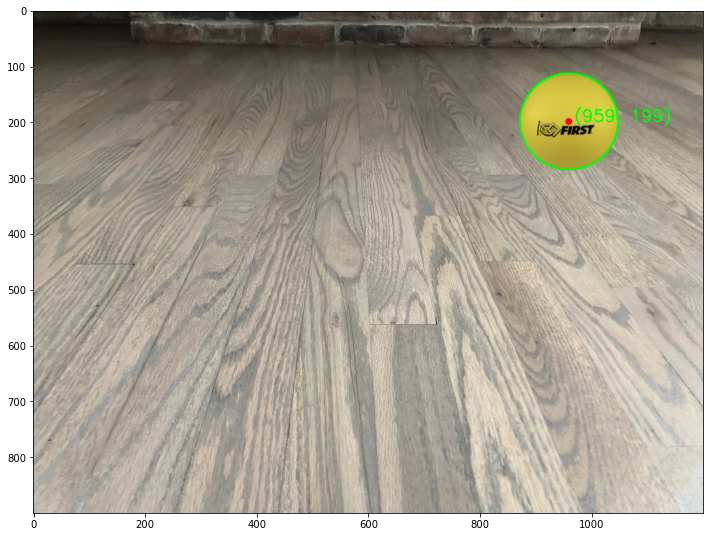

In [9]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

plt.figure(figsize=(12, 12))

ball_img = find_and_draw_circles(image, yellow_lower, yellow_upper, minimum_area_size, 25, True, False)

plt.imshow(ball_img)
plt.show()

#del(ball_img)

### Find the Angle of the Ball from the Camera

Here, I write, a function that will take an image and find the pictorial angle from the camera lens.  The camera lens here is to assume to be in the last row and middle column of the picture.

If the picture is of size 900 (number of rows) x 1200 (number of columns) as illustrated above then the camera lens is assumed to be at the pixel values of (900, 600).  Since we know that the center line right above the camera has an angle of zero degrees, we can use this fact to calculate the angle from the camera to pixel/point of interest.

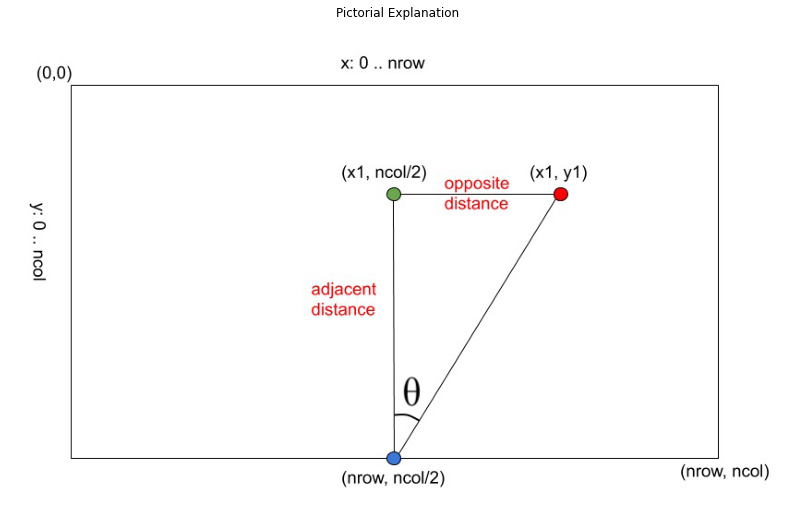

In [10]:
image1 = mpimg.imread('Angle_from_Center.jpg')

plt.figure(figsize=(14, 14))
plt.title("Pictorial Explanation")
plt.axis('off')
plt.imshow(image1)

plt.show()
del(image1)

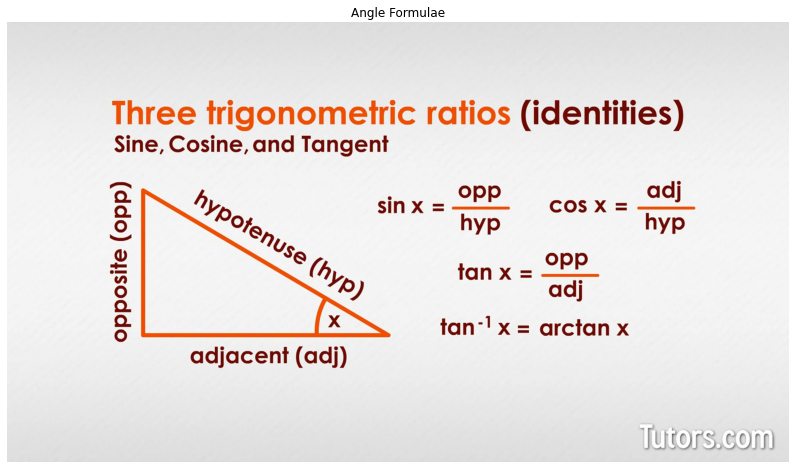

In [11]:
image1 = mpimg.imread('tutors-formulas-for-angle.jpg')

plt.figure(figsize=(14, 14))
plt.title("Angle Formulae")
plt.imshow(image1)
plt.axis('off')

plt.show()
del(image1)

Now, we have all the measurements we need to find the angle (theta) from camera to a point of interest.  The reason we are interested in the angle is that we can direct our robot on how much to turn.  This will guide the robot to position itself to be in front of the object.

In [12]:
def angle_from_center(image, point_of_interest, debug=False):
    """
    This takes a color image and a point (x, y) with the image
    and return the angle in degrees from the perspective of the camera
    from the middle bottom (width/2, height) coordinate of the image
    """
    
    # Find the camera's coordinates
    (_height, _width, _depth) = image.shape
    _x_camera = int(_width / 2)
    _y_camera = _height
    
    (_x1, _y1) = point_of_interest
    
    
    _adjacent_distance = _y_camera - _y1
    _opposite_distance = _x1 - _x_camera
    
    if debug:
        print("camera coordinates (%i, %i)" % (_x_camera, _y_camera))
        print("POI    coordinates (%i, %i)" % (_x1, _y1))
        print("opposite distance %i and adjacent distance %i "%(_opposite_distance, _adjacent_distance))
    
    if _adjacent_distance != 0:
        # POI is not on the same y-axis as the camera
        angle_radian = math.atan(_opposite_distance / _adjacent_distance)
        degree = round((angle_radian*180)/math.pi, 1)
        
    elif _opposite_distance > 0:
        # POI is on the same y-axis and to the right of center point
        degree = 90.0
    else:
        # POI is on the same y-axis and to the left of center point
        degree = -90.0
        
    return degree
   

Angle from center line is: 27.1 degrees


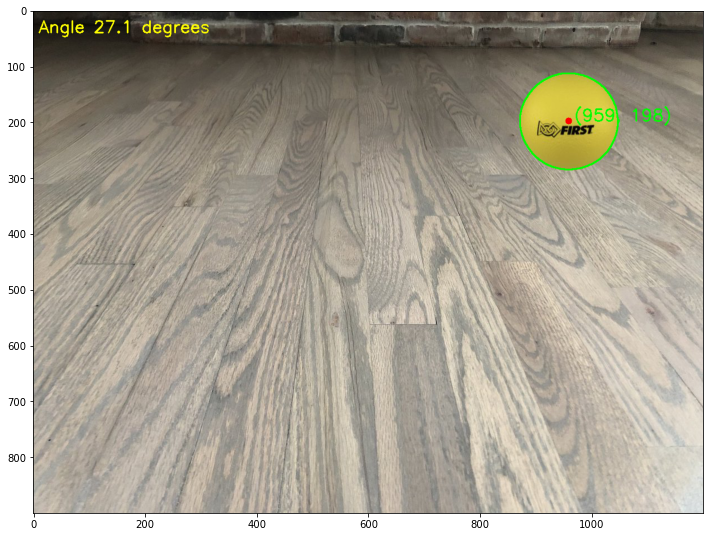

In [13]:
poi_angle = angle_from_center(image, (959, 198))
print("Angle from center line is: %.1f degrees"%(poi_angle))

yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

plt.figure(figsize=(12, 12))

ball_img = find_and_draw_circles(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, False)
cv2.putText(ball_img, "Angle %.1f degrees"%(poi_angle), (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

plt.imshow(ball_img)
plt.show()

del(ball_img, poi_angle)

In [14]:
print("Angle from center line is: %.1f degrees"%(angle_from_center(image, (1100, 500))))

Angle from center line is: 51.3 degrees


In [15]:
print("Angle from center line is: %.1f degrees"%(angle_from_center(image, (100, 500))))

Angle from center line is: -51.3 degrees


In [16]:
print("Angle from center line is: %.1f degrees"%(angle_from_center(image, (1100, 800))))

Angle from center line is: 78.7 degrees


In [17]:
print("Angle from center line is: %.1f degrees"%(angle_from_center(image, (200, 400))))

Angle from center line is: -38.7 degrees


In [18]:
print("Angle from center line is: %.1f degrees"%(angle_from_center(image, (1100, 900))))

Angle from center line is: 90.0 degrees


### Find the Width of the Ball

If we know the contour vertices, we can find the pixel width of the ball.  Since a ball is conveniently a circle from all perspective.  If we know the pixel width of the ball and we know the diameter of the ball, we can figure out how far the ball is from the camera.

In [19]:
def find_min_max_xcoord(vertices): 
    """
    Given a list of vertices for a contour, 
    return the min & max x-coordinate of the object and the width of the object in pixels
    """
    _first_pass = True
    
    for _v in vertices:
        
        _current_x = _v[0][0]
        
        if _first_pass == True:
            # initialize min and max x
            _min_x = _current_x
            _max_x = _min_x
            _first_pass = False
        else:
            if _current_x < _min_x:
                _min_x = _current_x
                
            if _current_x > _max_x:
                _max_x = _current_x
    
    _width_of_object = _max_x-_min_x
    
    return (_min_x, _max_x, _width_of_object)
        

In [20]:
# Set up a quick test for our find_min_max_xcoord( ) function
test_vertices = np.arange(10,110,10).reshape(5,1,2)
print(test_vertices)

[[[ 10  20]]

 [[ 30  40]]

 [[ 50  60]]

 [[ 70  80]]

 [[ 90 100]]]


In [21]:
# Get the min x value, max x value and the difference between min x & max x value
#   Should see 10 as min x, 90 as max x and 80 as the width

find_min_max_xcoord(test_vertices)

(10, 90, 80)

### Find the Distance of the Ball

If we place the same object at 2 different distances: one placement is close to the camera and the second placement is much further away from the camera.  We can interpolate the same object placed between those two reference points.

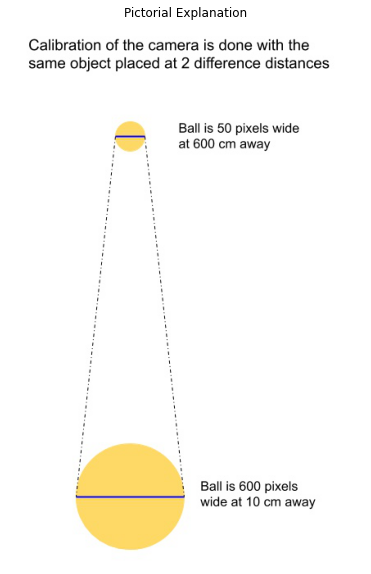

In [22]:
image1 = mpimg.imread('Perspective_ball_and_distance.jpg')

plt.figure(figsize=(10, 10))
plt.title("Pictorial Explanation")
plt.axis('off')
plt.imshow(image1)

plt.show()

del(image1)

In [23]:
def interpolate_distance_from_object(width):
    """
    Given a width in pixels
    Return the approximate distance from the camera's perspective
    """
    # You can tune it to a specific camera/environment
    # Set up the measured object and its distance as reference for extrapolation
    
    # The first is the reference point a near object
    #    For example, a 600 pixel wide circle is at 10 cm from the camera
    _MAX_WIDTH = 600
    _DIST_FOR_MAX_WIDTH_OBJECT = 10

    # The second is the reference point of a far away object
    #    For example, a 50 pixel wide circle is at 600 cm from the camera
    _MIN_WIDTH = 50
    _DIST_FOR_MIN_WIDTH_OBJECT = 600
    
    # If the object is wider than our _MAX_WIDTH measurement
    # we'll just say it as far as the closest object
    if width > _MAX_WIDTH:
        _approximate_distance = _DIST_FOR_MAX_WIDTH_OBJECT
        
    elif width < _MIN_WIDTH:
        # If width is smaller than our smallest measurement
        # we'll say it is as far as the farthest object
        _approximate_distance = _DIST_FOR_MIN_WIDTH_OBJECT
    
    else:
        # Solving the equation for y = mx + b
        #   m = _slope
        #   b = _constant
        _slope = (_DIST_FOR_MAX_WIDTH_OBJECT - _DIST_FOR_MIN_WIDTH_OBJECT)/(_MAX_WIDTH - _MIN_WIDTH)
        _constant = _DIST_FOR_MIN_WIDTH_OBJECT - _slope * _MIN_WIDTH
    
        # Now, we interapolate the distance from our actual measurements in cm
        _approximate_distance = round(_slope * width + _constant, 2)
    
    return _approximate_distance

## Let's test our interpolation function

Remember we provided __two__ reference points in the function?  We should get our reference points back if we input the original width for the small and large objects.

In [24]:
print("A  50 pixel-wide cirle is at", interpolate_distance_from_object(50), "cm from the camera")
print("A 600 pixel-wide cirle is at", interpolate_distance_from_object(600), "cm from the camera")
print("A 300 pixel-wide cirle is at", interpolate_distance_from_object(300), "cm from the camera")

A  50 pixel-wide cirle is at 600.0 cm from the camera
A 600 pixel-wide cirle is at 10.0 cm from the camera
A 300 pixel-wide cirle is at 331.82 cm from the camera


## Let's Put it All Together

Now, we have a function that can find an angle and another the can calculate the distance from the camera, we can put all the pieces together.

In [25]:
def find_distance(image, lower_color_hsv, upper_color_hsv, min_area_size, 
                  kernel=3, output_text=True, print_centroids=True):
    """
    This takes in a color image, a lower HSV color and an upper HSV color range
    and a minimum pixel area size to detect a circle
    """
    _image = image.copy()
    
    # Blur and convert image to HSV
    _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
    _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
    # Mask the image using the lower/upper hsv range
    _mask_img = cv2.inRange(_hsv_img, lower_color_hsv, upper_color_hsv)
    
    # Find the contours
    _contours = cv2.findContours(_mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    _contours = imutils.grab_contours(_contours)
   
    # Initialize ShapeDetector
    _sd = ShapeDetector()
       
    # Loop through contours to find circles
    for _c in _contours:
        # compute the center of the contour, then detect the name of the
        # shape using only the contour
        
        # M is the moment (weighted average of the image pixel intensity)
        _M = cv2.moments(_c)
        _area = cv2.contourArea(_c)

        # cX is the x coordinate of the centroid
        # cY is the y coordinate of the centroid
        # We wrap this in a try/except clause due to a division
        #    so we can trap a division by zero
        try:
            _cX = int((_M["m10"] / _M["m00"]))
            _cY = int((_M["m01"] / _M["m00"]))
        except:
            _cX = 0
            _cY = 0

        _shape = _sd.detect(_c)

        if (_shape == "circle") and (_area >= min_area_size):
            
            # Find the width of the object
            (_min_x, _max_x, _width) = find_min_max_xcoord(_c)
            
            # Find the distance of the object
            _approx_distance = interpolate_distance_from_object(_width)
            
            # Find the angle from the camera
            _poi_angle = angle_from_center(image, (_cX, _cY))
            
            # Output angle and distance to the image
            cv2.putText(_image, "Angle: %.1f degrees"%(_poi_angle), (10, 40), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
            cv2.putText(_image, "Distance : %.1f cm"%(_approx_distance), (10, 80), 
                        cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

            # Drawing each contour in green (0, 255, 0) on top of the original image
            cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)
            cv2.circle(_image,(_cX, _cY), 6, (255, 0, 0), -1)
            
            if output_text:
                # Display the text for the image shape
                _center = "(%i, %i)"%(_cX, _cY)
                cv2.putText(_image, _center, (_cX+10, _cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
            if print_centroids:
                print("shape:", _shape, " area: ", _area, "center: (", _cX,",", _cY,")")
                print("min x: %i, max x: %i, width: %i"%(_min_x, _max_x, _width))
    
    return _image

shape: circle  area:  23667.0 center: ( 959 , 198 )
min x: 872, max x: 1047, width: 175


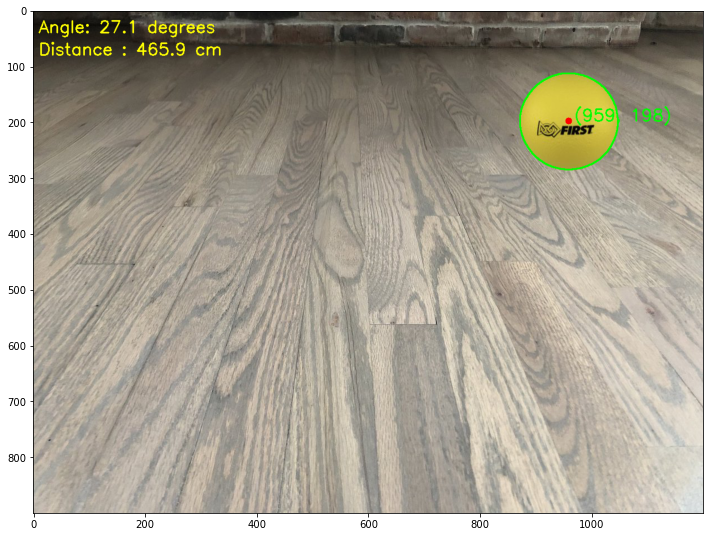

In [26]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_rightball1.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

shape: circle  area:  234562.5 center: ( 1015 , 806 )
min x: 741, max x: 1291, width: 550


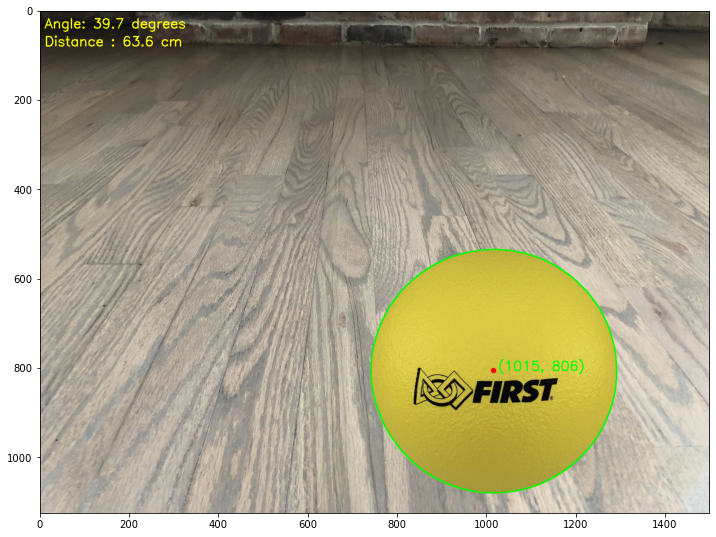

In [27]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_rightball2.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

shape: circle  area:  4767.0 center: ( 1381 , 59 )
min x: 1342, max x: 1421, width: 79


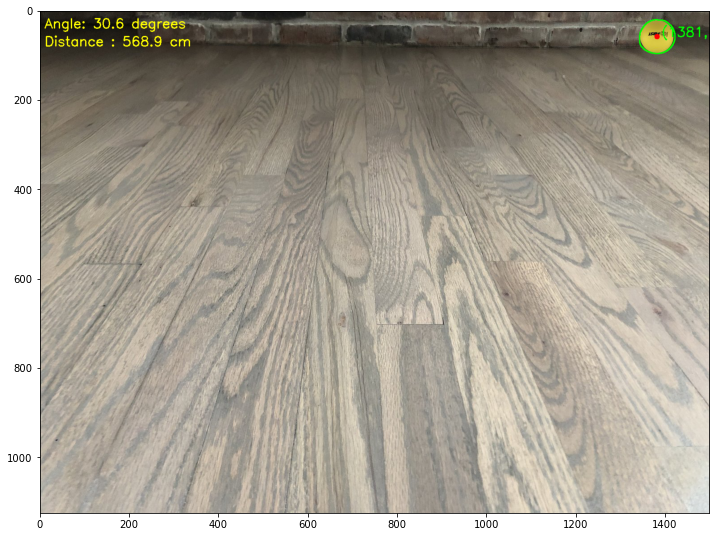

In [28]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_rightball3.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

shape: circle  area:  111807.5 center: ( 276 , 655 )
min x: 88, max x: 464, width: 376


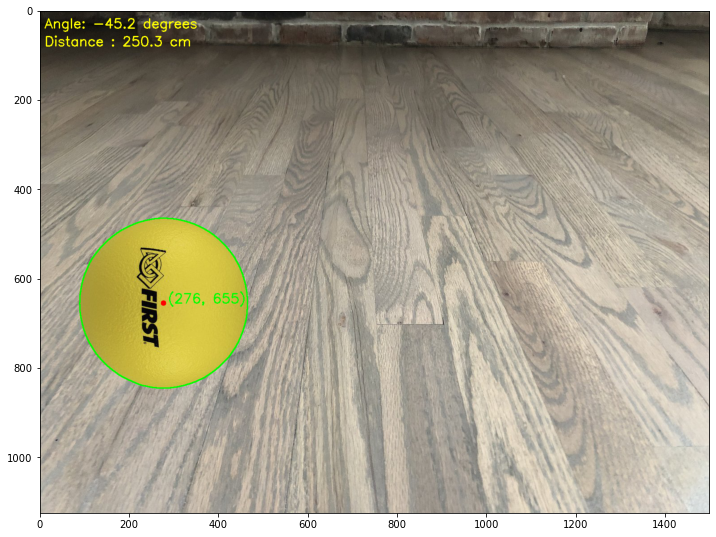

In [29]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_leftball1.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

yellow_lower = np.array([90, 100, 100])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 5000

del(ball_img)

shape: circle  area:  6434.5 center: ( 452 , 80 )
min x: 407, max x: 499, width: 92


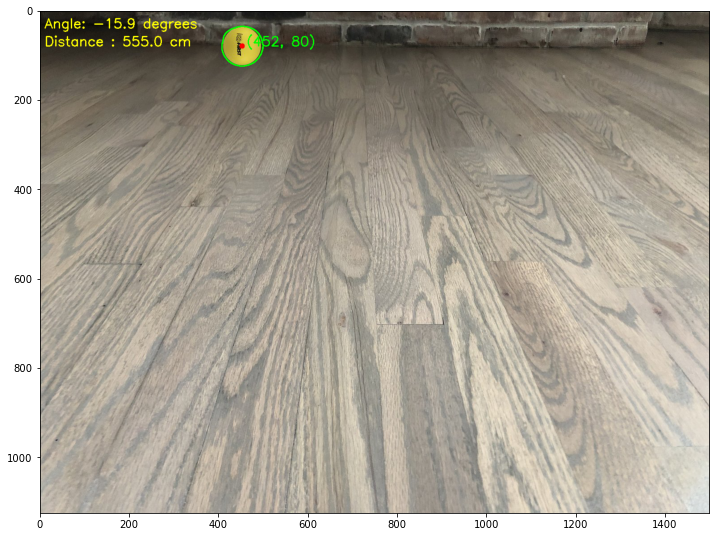

In [30]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_leftball2.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

shape: circle  area:  94995.5 center: ( 416 , 567 )
min x: 243, max x: 590, width: 347


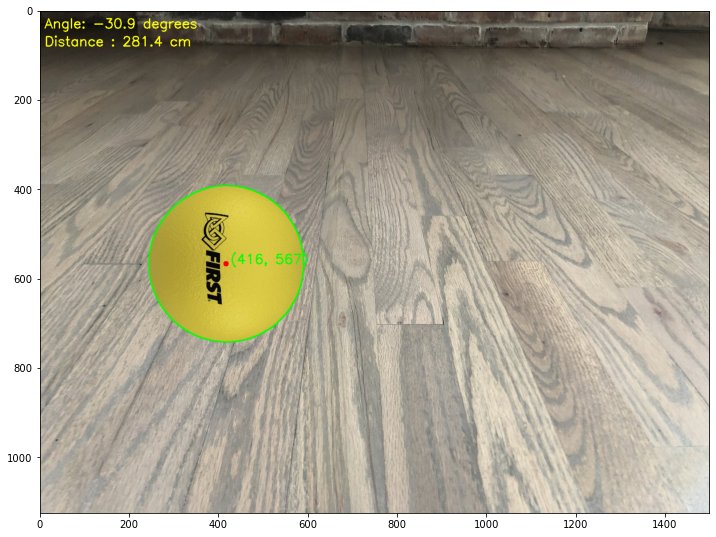

In [31]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_leftball3.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

## Wide Angle and Perspective Distortions

I've presented a very simplified way to find angle and distance for a ball in our image.  There are some serious and commonly known distortions in computer vision.  These distortions will not map linearly onto the image.

Camera calibration can be a deep topic so I will reference the introduction of the topic here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_calib3d/py_calibration/py_calibration.html

However, our simpler method is only intented to guide our robot to head in the right direction.  Also, we are processing videos and as we update our image as the robot move closer to the ball, our subsequent predictions will become more linear in nature.

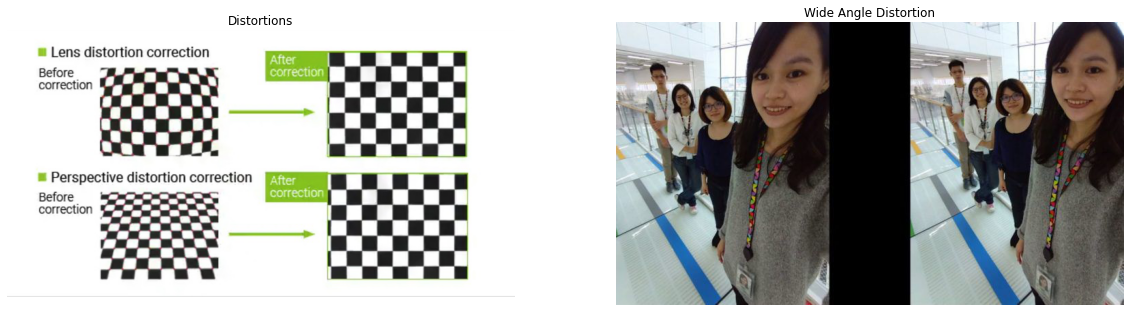

In [32]:
image1 = mpimg.imread('lens_distortions.jpg')
image2 = mpimg.imread('wideangle_distortion.jpg')

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.title("Distortions")
plt.axis('off')
plt.imshow(image1)

plt.subplot(1, 2, 2)
plt.title("Wide Angle Distortion")
plt.imshow(image2)
plt.axis('off')

plt.show()

del(image1, image2)

## Challenge

So far we have been able to detect 1 ball and it's distance and angle from the camera.  The challenge is to improve on the existing function so it only output the closest ball information in the upper left corner. The reason we want to find the closest ball is to help direct the robot to pick up the closest ball if it exists.
No sense going 10 meters away to pickup a ball if there is one only 10 cm away, right?

I've provided the function code below as find_closest_ball( ). 

shape: circle  area:  141170.5 center: ( 1265 , 889 )
min x: 1052, max x: 1478, width: 426
shape: circle  area:  39752.0 center: ( 354 , 420 )
min x: 243, max x: 465, width: 222
shape: circle  area:  10823.5 center: ( 966 , 79 )
min x: 906, max x: 1026, width: 120


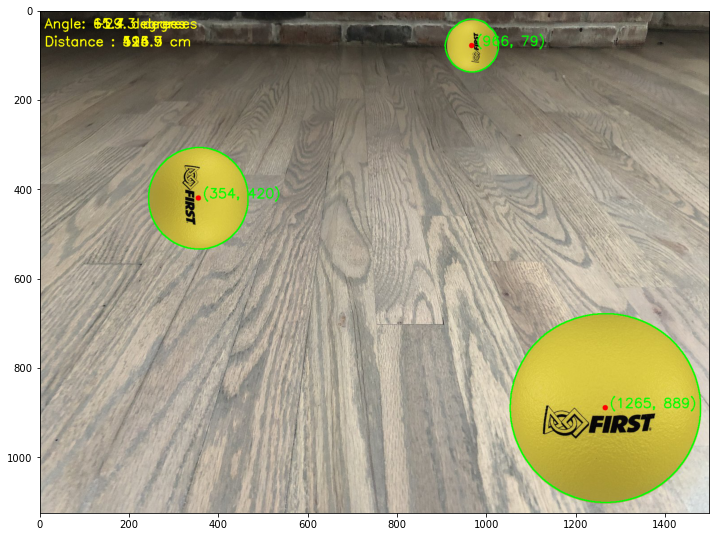

In [33]:
yellow_lower = np.array([90, 110, 70])
yellow_upper = np.array([100, 255, 255])
minimum_area_size = 4500

image = mpimg.imread('woodfloor_3balls.jpg')
ball_img = find_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

plt.figure(figsize=(12, 12))
plt.imshow(ball_img)
plt.show()

del(ball_img)

In [34]:
# def find_closest_distance(image, lower_color_hsv, upper_color_hsv, min_area_size, 
#                   kernel=3, output_text=True, print_centroids=True):
#     """
#     This takes in a color image, a lower HSV color and an upper HSV color range
#     and a minimum pixel area size to detect a circle
#     """
#     _image = image.copy()
    
#     # Blur and convert image to HSV
#     _blur_img = cv2.GaussianBlur(_image, (kernel,kernel), 0)
#     _hsv_img  = cv2.cvtColor(_blur_img, cv2.COLOR_BGR2HSV)
    
#     # Mask the image using the lower/upper hsv range
#     _mask_img = cv2.inRange(_hsv_img, lower_color_hsv, upper_color_hsv)
    
#     # Find the contours
#     _contours = cv2.findContours(_mask_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#     _contours = imutils.grab_contours(_contours)
   
#     # Initialize ShapeDetector
#     _sd = ShapeDetector()
       
#     # Loop through contours to find circles
#     for _c in _contours:
#         # compute the center of the contour, then detect the name of the
#         # shape using only the contour
        
#         # M is the moment (weighted average of the image pixel intensity)
#         _M = cv2.moments(_c)
#         _area = cv2.contourArea(_c)

#         # cX is the x coordinate of the centroid
#         # cY is the y coordinate of the centroid
#         # We wrap this in a try/except clause due to a division
#         #    so we can trap a division by zero
#         try:
#             _cX = int((_M["m10"] / _M["m00"]))
#             _cY = int((_M["m01"] / _M["m00"]))
#         except:
#             _cX = 0
#             _cY = 0

#         _shape = _sd.detect(_c)

#         if (_shape == "circle") and (_area >= min_area_size):
            
#             # Find the width of the object
#             (_min_x, _max_x, _width) = find_min_max_xcoord(_c)
            
#             # Find the distance of the object
#             _approx_distance = interpolate_distance_from_object(_width)
            
#             # Find the angle from the camera
#             _poi_angle = angle_from_center(image, (_cX, _cY))
            
#             # Output angle and distance to the image
#             cv2.putText(_image, "Angle: %.1f degrees"%(_poi_angle), (10, 40), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)
#             cv2.putText(_image, "Distance : %.1f cm"%(_approx_distance), (10, 80), 
#                         cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 0), 2)

#             # Drawing each contour in green (0, 255, 0) on top of the original image
#             cv2.drawContours(_image, [_c], -1, (0, 255, 0), 2)
#             cv2.circle(_image,(_cX, _cY), 6, (255, 0, 0), -1)
            
#             if output_text:
#                 # Display the text for the image shape
#                 _center = "(%i, %i)"%(_cX, _cY)
#                 cv2.putText(_image, _center, (_cX+10, _cY), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 2)
                
#             if print_centroids:
#                 print("shape:", _shape, " area: ", _area, "center: (", _cX,",", _cY,")")
#                 print("min x: %i, max x: %i, width: %i"%(_min_x, _max_x, _width))
    
#     return _image

In [35]:
## Test your function here

# yellow_lower = np.array([90, 110, 70])
# yellow_upper = np.array([100, 255, 255])
# minimum_area_size = 4500

# image = mpimg.imread('woodfloor_3balls.jpg')
# ball_img = find_closest_distance(image, yellow_lower, yellow_upper, minimum_area_size, 31, True, True)

# plt.figure(figsize=(12, 12))
# plt.imshow(ball_img)
# plt.show()

# del(ball_img)